# Pretrained embedding

By cutting off the last layer of the network, we can obtain a feature vector (also *embedding*, *descriptor* or *high-level representation*) of the input image.

In [1]:
import torch


from lib.cnn_classifiers import get_cut_off_cnn, get_im_embedding

## Compose a set of gallery and query images

In [2]:
from PIL import Image
from pathlib import Path

gallery_img_paths = [
    'data/sodas/CocaCola2L/CocaCola2L_00.jpg',
    'data/sodas/Fanta2L/Fanta2L_00.jpg',
    'data/sodas/Pepsi2L/Pepsi2L_00.jpg',
    'data/sodas/Sprite2L/Sprite2L_0000.jpg'
]

query_img_paths = [
    img_path
    for img_path in Path('data/sodas/').glob('**/*.jpg')
    if str(img_path) not in gallery_img_paths
]

In [3]:
gallery_ims = [
    Image.open(img_path)
    for img_path in gallery_img_paths
]

query_ims = [
    Image.open(img_path)
    for img_path in query_img_paths
]

## Compute gallery and query embeddings

In [4]:
model = get_cut_off_cnn('resnet50').eval()

In [5]:
gallery_embs = torch.vstack([
    get_im_embedding(im, model)
    for im in gallery_ims
])

query_embs = torch.vstack([
    get_im_embedding(im, model)
    for im in query_ims
])

## Match the queries with the items in the gallery

We compute the [cosine similarity score](https://en.wikipedia.org/wiki/Cosine_similarity) between each gallery embedding and each query embedding, which is the **cosine of the angle between the embeddings**. When embeddings are **the same**, the angle between them will be zero and the cosine of the angle will be **1**. **Perpendicular** embeddings have a cosine similarity of **0** and **opposite** embeddings have a cosine similarity of **-1**.

When the embeddings are already normalized, computing the cosine similarity boils down to a **matrix multiplication** of the matrix formed by the gallery embeddings and the matrix formed by the query embeddings.

Note that for normalized embeddings, sorting pairs of embeddings from smallest to largest distance will yield the same ranking as sorting them for largest to smallest cosine similarity score. However, computing the distance requires more computations and can easily be **five times slower**, as we can see below. Hence, we prefer to use cosine similarity.

In [6]:
%%timeit
torch.cdist(query_embs, gallery_embs)

254 µs ± 6.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
query_embs.matmul(gallery_embs.T)

48.3 µs ± 179 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
score_mat = query_embs.matmul(gallery_embs.T)

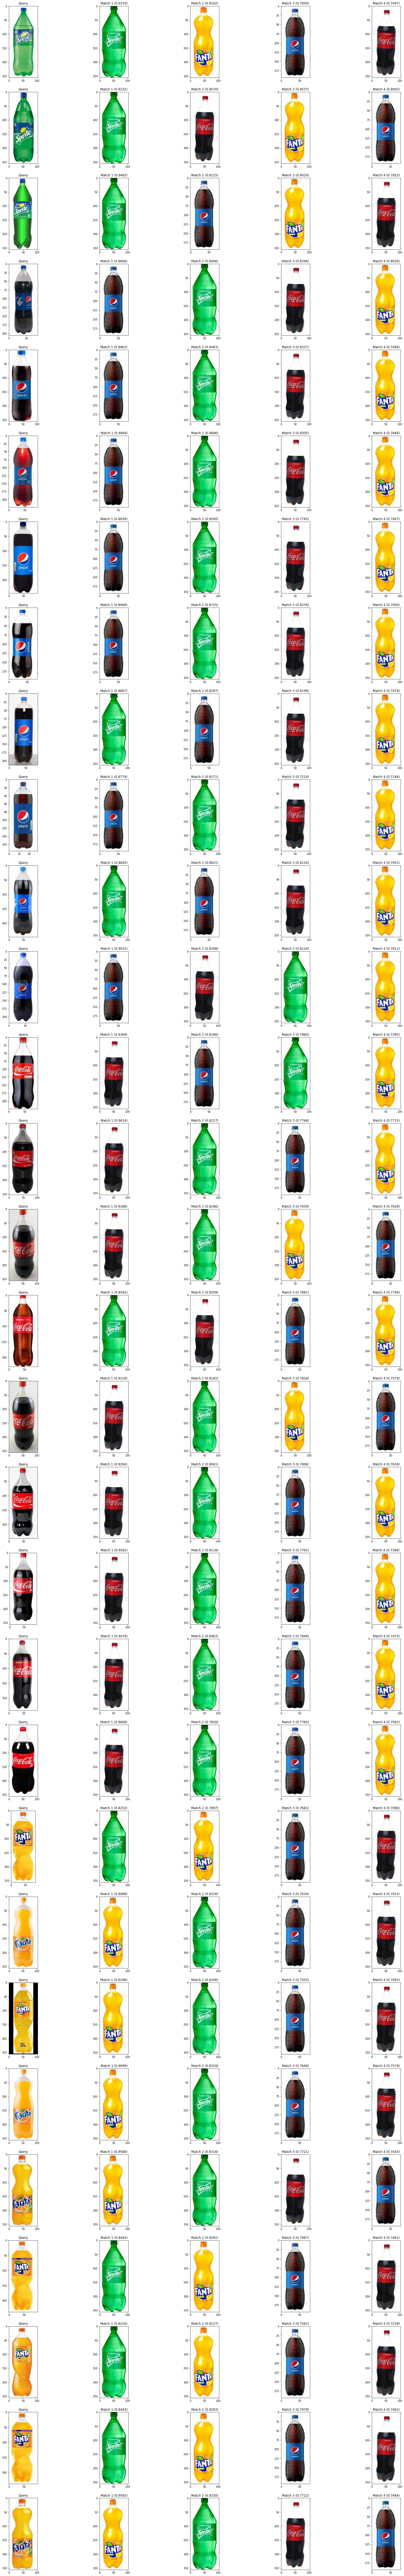

In [9]:
import matplotlib.pyplot as plt
import numpy as np


ncols = len(gallery_ims) + 1
nrows = len(query_ims)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6))

for i, im in enumerate(query_ims):
    idxs = score_mat[i].argsort(descending=True).numpy()

    axes[i][0].set_title('Query')
    axes[i][0].imshow(np.array(im))

    for j, g_idx in enumerate(idxs):
        g_im = gallery_ims[g_idx]
        axes[i][j + 1].set_title(f'Match {j + 1} ({score_mat[i][g_idx]:.4f})')
        axes[i][j + 1].imshow(np.array(g_im))